Olá, Suiane

Meu nome é Ramon. Ao ao longo do texto farei algumas observações sobre melhorias no código. Nas partes em que não houver comentários, está tudo certo, ok? Estarei aberto a feedbacks e discussões sobre o tema.

**Peço que mantenha e não altere os comentários que eu fizer por aqui para que possamos nos localizar posteriormente, ok?**

Mais uma coisa, vamos utilizar um código de cores para você entender os meus feedbacks no seu notebook. Funciona assim:

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Sucesso. Tudo foi feito corretamente.
</div>

<div class="alert alert-block alert-warning">
<b>Comentário do revisor: </b> <a class="tocSkip"></a>

Alerta não crítco, mas que pode ser corrigido para melhoria geral no seu código/análise
</div>

<div class="alert alert-block alert-danger">

<b>Comentário do revisor: </b> <a class="tocSkip"></a>
    
Erro que precisa ser consertado, caso contrário seu projeto **não** será aceito.
</div>

Você pode me responder usando isso:

<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> <a class="tocSkip"></a>
</div>


###

<div class="alert alert-block alert-success">
<b>Comentário Geral do Revisor</b> <a class="tocSkip"></a>

Obrigado por enviar seu projeto. 
    
Parabéns, você fez um bom trabalho.

Como pontos fortes do projeto, destaco:
- Código simples e eficiente (sem loop desnecessário)
- Uso adequado dos recursos da lição
- Apresentação está muito boa
- Dashaboard está bom. Porém, senti falta de gráfico sobre o tempo médio de espera
- Gostei da clusterização usando k-means e da análise de corhort

<span class="text-danger">Porém, há espaço para melhorias: </span>
 * <span class="text-danger"> ajustar os testes de hipótese; ajustar critério para definir piores operadores; explicar um gráfico </span>


Portanto, sugiro que você corrija os pontos indicados.
    
Se você tiver alguma dúvida sobre de algo que você não tenha entendido, sinta-se à vontade para perguntar ao tutor ou deixar um comentário em **azul** para que, na próxima iteração, eu possa responder.

Conte conosco. Lembre-se de que você pode tirar dúvidas com revisores usando os comentários ou buscar ajuda de um tutor.
Bom trabalho. 


</div>





<div class="alert alert-block alert-success">
<b> Comentário do revisor V2: </b> <a class="tocSkip"></a>

Houve melhoras no projeto. Parabéns pela dedicação. Um teste de hipótese ainda aprseenta o problema de usar a mesma variável para testar e recortar as amostras. Oriento remover o teste pois os outros dois estão adequados ou ajustar.

Como posso te ajudar?
</div>


<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> Optei por excluir o teste. Além disso, esqueci de informar que inclui um gráfico sobre tempo de espera no dashboard. <a class="tocSkip"></a>
</div>

<div class="alert alert-block alert-success">
<b> Comentário Geral do revisor: </b> <a class="tocSkip"></a>

Tudo certo agora. Como há muitos operadores, o gráfico do tempo de espera fica um tanto poluído. Uma opção é plotar o tempo de espera em funçaõ de outra variável categória (ex: faixa produtividade)
Parabéns pelo empenho. Desejo sucesso na jornada.

</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df= pd.read_csv('/datasets/telecom_dataset_us.csv')
df2= pd.read_csv('/datasets/telecom_clients_us.csv')

## Limpeza e processamento de dados

1. Remoção de registros sem operador

In [3]:
df.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [4]:
df2.sample(3)

,user_id,tariff_plan,date_start
253,168271,C,2019-10-18
289,167500,C,2019-09-18
647,166844,B,2019-08-21


In [5]:
df.sample(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
26642,167150,2019-11-19 00:00:00+03:00,out,False,905564.0,False,8,1300,1370
25998,167150,2019-10-02 00:00:00+03:00,out,True,905566.0,True,1,0,0
42682,167976,2019-10-30 00:00:00+03:00,in,False,934428.0,False,2,139,185


In [6]:
df = df.dropna(subset=['operator_id'])

In [7]:
df['operator_id'] = df['operator_id'].astype(int)

2. Conversão de tipos de dados e padronização de datas

In [8]:
df['date']=pd.to_datetime(df['date'])
df['date'] = (
    df['date']
    .dt.tz_convert('UTC')
    .dt.tz_localize(None)
)

In [9]:
df['dia']    = df['date'].dt.day
df['semana'] = df['date'].dt.isocalendar().week
df['mes']    = df['date'].dt.month

In [10]:
df2['date_start']=pd.to_datetime(df2['date_start'])

In [11]:
df2['dia']    = df2['date_start'].dt.day
df2['semana'] = df2['date_start'].dt.isocalendar().week
df2['mes']    = df2['date_start'].dt.month

In [12]:
df['internal'] = df['internal'].astype(bool)

3. Tratamento de valores inconsistentes

In [13]:
df['erro_duracao'] = df['total_call_duration'] < df['call_duration']

In [14]:
df['erro_duracao_negativa'] = (
    (df['call_duration'] <= 0) &
    (df['is_missed_call'] == False)
)

In [15]:
df_ = df[
    ~(df['erro_duracao'] | df['erro_duracao_negativa'])
].copy()

4. Segmentação estrutural dos dados

In [16]:
df_['call_type'] = np.select(
    [
        (df_['direction'] == 'in') & (df_['internal']),
        (df_['direction'] == 'in') & (~df_['internal']),
        (df_['direction'] == 'out') & (df_['internal']),
        (df_['direction'] == 'out') & (~df_['internal']),
    ],
    [
        'inbound_internal',
        'inbound_external',
        'outbound_internal',
        'outbound_external'
    ]
)

5. Agregação por operador

In [17]:
operadores= (
    df_
    .groupby('operator_id')
    .agg(
        chamadas=('calls_count', 'sum'),
        chamadas_perdidas=('is_missed_call', 'sum'),
        duracao_total_media=('total_call_duration', 'mean'),
        duracao_media=('call_duration', 'mean')
    )
)

In [18]:
inbound = df_[df_['direction'] == 'in']

operadores_inbound = (
    inbound
    .groupby('operator_id')
    .agg(
        chamadas_inbound=('calls_count', 'sum'),
        perdidas_inbound=('is_missed_call', 'sum'),
        duracao_total_media_in=('total_call_duration', 'mean'),
        duracao_media_in=('call_duration', 'mean')
    )
)

In [19]:
outbound = df_[df_['direction'] == 'out']

operadores_outbound = (
    outbound
    .groupby('operator_id')
    .agg(
        chamadas_outbound=('calls_count', 'sum'),
        duracao_media_out=('call_duration', 'mean')
    )
)

In [20]:

operadores_final = operadores.merge(
    operadores_inbound,
    on='operator_id',
    how='left'
).merge(
    operadores_outbound,
    on='operator_id',
    how='left'
)

In [21]:
operadores_final = operadores_final.fillna(0)

6. Criação de variáveis derivadas

In [22]:
df_['tempo_espera']=df_['total_call_duration']-df_['call_duration']

In [23]:
espera_operador = (
    df_[df_['direction'] == 'in']
    .groupby('operator_id')['tempo_espera']
    .mean()
    .reset_index(name='tempo_espera_medio')
)

operadores_final = operadores_final.merge(
    espera_operador,
    on='operator_id',
    how='left'
)

In [24]:
dias_ativos = (
    df_
    .groupby('operator_id')['date']
    .nunique()
    .reset_index(name='dias_ativos')
)

In [25]:
operadores_final = operadores_final.merge(
    dias_ativos,
    on='operator_id',
    how='left'
)

In [26]:
operadores_final['dias_ativos'] = operadores_final['dias_ativos'].fillna(0)

## Análise de dados

1. Análise da taxa de chamadas perdidas por operador

In [27]:
# Cálculo da proporção de chamadas perdidas

inbound_op = (
    df[df['direction'] == 'in']
    .groupby('operator_id')['calls_count']
    .sum()
    .rename('inbound_total')
)

In [28]:
inbound_perdido_op = (
    df[
        (df['direction'] == 'in') &
        (df['is_missed_call'] == True)
    ]
    .groupby('operator_id')['calls_count']
    .sum()
    .rename('inbound_perdido')
)

In [29]:
abandono_op = (
    inbound_op
    .to_frame()
    .join(inbound_perdido_op, how='left')
    .fillna(0)
)

abandono_op['taxa_abandono_operador'] = (
    abandono_op['inbound_perdido'] /
    abandono_op['inbound_total']
)

abandono_op=abandono_op.reset_index()

In [30]:
abandono_op['taxa_abandono_operador'].describe()

count    754.000000
mean       0.017169
std        0.066000
min        0.000000
25%        0.000000
50%        0.000000
75%        0.006536
max        1.000000
Name: taxa_abandono_operador, dtype: float64

In [31]:
operadores_final = operadores_final.merge(
    abandono_op[['operator_id', 'taxa_abandono_operador']],
    on='operator_id',
    how='left'
)

In [32]:
#operadores_final['duracao_total_media'] = operadores_final['duracao_total_media_x']
#operadores_final = operadores_final.drop(
    #columns=['duracao_total_media_x', 'duracao_total_media_y'])

In [33]:
operadores_final

,operator_id,chamadas,chamadas_perdidas,duracao_total_media,duracao_media,chamadas_inbound,perdidas_inbound,duracao_total_media_in,duracao_media_in,chamadas_outbound,duracao_media_out,tempo_espera_medio,dias_ativos,taxa_abandono_operador
0,879896,1131,50,761.148438,650.476562,60.0,0.0,273.086957,246.173913,1071.0,739.038095,26.913043,50,0.0
1,879898,7974,100,1561.155378,1111.067729,118.0,0.0,138.437500,110.234375,7856.0,1453.598930,28.203125,84,0.0
2,880020,54,7,119.272727,104.090909,8.0,0.0,50.250000,43.000000,46.0,139.000000,7.250000,14,0.0
3,880022,219,33,298.407895,240.842105,8.0,0.0,78.000000,64.000000,211.0,261.647059,14.000000,42,0.0
4,880026,2439,94,978.111111,856.939394,25.0,0.0,93.789474,85.894737,2414.0,938.782123,7.894737,77,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,972410,77,2,1318.750000,944.250000,0.0,0.0,0.000000,0.000000,77.0,944.250000,NaN,2,NaN
1088,972412,61,2,909.600000,699.600000,1.0,0.0,145.000000,120.000000,60.0,844.500000,25.000000,2,0.0
1089,972460,70,3,346.888889,257.888889,2.0,0.0,18.000000,14.000000,68.0,327.571429,4.000000,2,0.0
1090,973120,3,1,12.500000,2.500000,0.0,0.0,0.000000,0.000000,3.0,2.500000,NaN,1,NaN


In [34]:
# Cálculo do share de chamadas perdidas

operadores_final['share_perdidas'] = operadores_final['chamadas_perdidas']/operadores_final['chamadas_perdidas'].sum()
operadores_final

,operator_id,chamadas,chamadas_perdidas,duracao_total_media,duracao_media,chamadas_inbound,perdidas_inbound,duracao_total_media_in,duracao_media_in,chamadas_outbound,duracao_media_out,tempo_espera_medio,dias_ativos,taxa_abandono_operador,share_perdidas
0,879896,1131,50,761.148438,650.476562,60.0,0.0,273.086957,246.173913,1071.0,739.038095,26.913043,50,0.0,0.003222
1,879898,7974,100,1561.155378,1111.067729,118.0,0.0,138.437500,110.234375,7856.0,1453.598930,28.203125,84,0.0,0.006444
2,880020,54,7,119.272727,104.090909,8.0,0.0,50.250000,43.000000,46.0,139.000000,7.250000,14,0.0,0.000451
3,880022,219,33,298.407895,240.842105,8.0,0.0,78.000000,64.000000,211.0,261.647059,14.000000,42,0.0,0.002127
4,880026,2439,94,978.111111,856.939394,25.0,0.0,93.789474,85.894737,2414.0,938.782123,7.894737,77,0.0,0.006057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,972410,77,2,1318.750000,944.250000,0.0,0.0,0.000000,0.000000,77.0,944.250000,NaN,2,NaN,0.000129
1088,972412,61,2,909.600000,699.600000,1.0,0.0,145.000000,120.000000,60.0,844.500000,25.000000,2,0.0,0.000129
1089,972460,70,3,346.888889,257.888889,2.0,0.0,18.000000,14.000000,68.0,327.571429,4.000000,2,0.0,0.000193
1090,973120,3,1,12.500000,2.500000,0.0,0.0,0.000000,0.000000,3.0,2.500000,NaN,1,NaN,0.000064


<s>
    <div class="alert alert-block alert-warning">
<b> Comentário Geral do revisor: </b> <a class="tocSkip"></a>

Não é comum nome de variável começando com %
</div>


In [35]:
df_validos = abandono_op[abandono_op['inbound_total'] >= 50].copy()

q1 = df_validos['taxa_abandono_operador'].quantile(0.25)
q3 = df_validos['taxa_abandono_operador'].quantile(0.75)
iqr = q3 - q1

limite_superior = q3 + 1.5 * iqr

piores_operadores = df_validos[
    df_validos['taxa_abandono_operador'] > limite_superior
].sort_values('taxa_abandono_operador', ascending=False)

piores_operadores.reset_index(drop=True)

,operator_id,inbound_total,inbound_perdido,taxa_abandono_operador
0,944226,202,38.0,0.188119
1,905862,112,15.0,0.133929
2,959312,58,7.0,0.120690
3,944216,288,32.0,0.111111
4,944222,192,17.0,0.088542
5,921814,52,4.0,0.076923
6,920706,81,6.0,0.074074
7,951508,339,24.0,0.070796
8,945046,73,5.0,0.068493
9,944220,329,21.0,0.063830


<div class="alert alert-block alert-danger">
<b> Comentário Geral do revisor: </b> <a class="tocSkip"></a>

- pegar os 10 primeiros como os piores não é adequado
- oriento usar critério estatístico: usar o limite superior do IQR ou z-score
- é como se fossêmos identificar outliers
</div>


<div class="alert alert-block alert-success">
<b> Comentário do revisor V2: </b> <a class="tocSkip"></a>

Correto
</div>


2. Comparação do tempo médio de espera

In [36]:
piores_ids = piores_operadores['operator_id'].tolist()

piores = operadores_final[
    operadores_final['operator_id'].isin(piores_ids)
]


In [37]:
media_geral = piores['tempo_espera_medio'].mean()

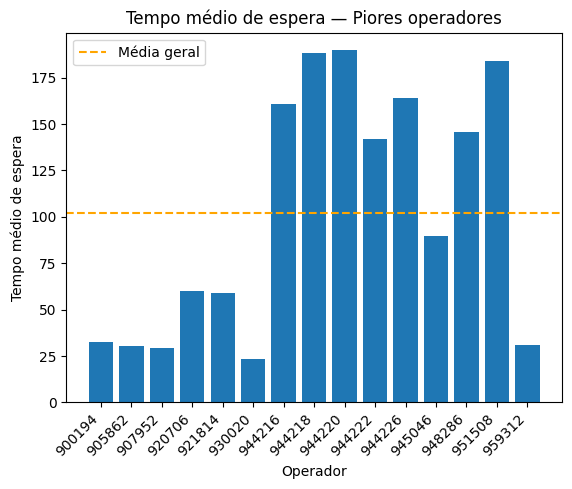

In [38]:
plt.figure()

plt.bar(
    piores['operator_id'].astype(str),
    piores['tempo_espera_medio']
)

plt.axhline(
    y=media_geral,
    linestyle='--',
    label='Média geral',
    color = 'orange'
)

plt.ylabel('Tempo médio de espera')
plt.xlabel('Operador')
plt.title('Tempo médio de espera — Piores operadores')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.show()


Foram identificados operadores com taxa de abandono acima da média, associada a tempo de espera elevado em chamadas inbound. Esse comportamento indica ineficiência operacional clara: o cliente entra em contato, espera demais e desiste.

O impacto é direto no negócio: perda de chamadas, pior experiência do cliente e aumento de custo operacional sem retorno.

Ação recomendada: intervir nesses operadores com ajuste de carga, escala ou treinamento, pois a redução do tempo de espera tende a diminuir rapidamente o abandono.

<div class="alert alert-block alert-danger">
<b> Comentário Geral do revisor: </b> <a class="tocSkip"></a>

- acredito que não consegui entender o gráfico 
- a media geral do tempo de espera está acima do tempo médio dos piores operadores, logo os piores operadores apresentam tempo de espera inferior à média. Isso não faz muito sentido
- poderia me explicar melhor?
</div>


<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b>  
    Inicialmente, a identificação dos piores operadores foi feita por ranking, o que se mostrou inadequado. O critério foi então ajustado para uma abordagem estatística, tratando operadores com taxa de abandono acima do limite superior do IQR como outliers.

No gráfico de tempo médio de espera, a linha de referência foi corrigida para representar a média apenas do grupo de operadores críticos, evitando comparações indevidas com a média global e garantindo coerência analítica. Antes não estava fazendo sentido mesmo porque errei na hora de calcular a média. <a class="tocSkip"></a>
</div>

<div class="alert alert-block alert-success">
<b> Comentário do revisor V2: </b> <a class="tocSkip"></a>

Entendi. Obrigado pela explicação. Agora faz mais sentido. Média geral remete à média de todo o dataset, mas entendi que é a média dos piores operadores
</div>


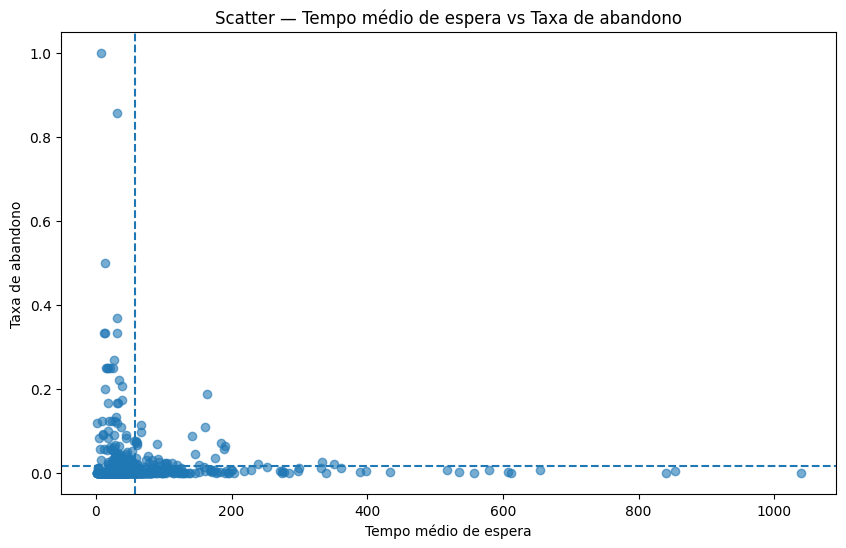

In [39]:
plt.figure(figsize=(10, 6))

plt.scatter(
    operadores_final['tempo_espera_medio'],
    operadores_final['taxa_abandono_operador'],
    alpha=0.6
)

plt.axvline(
    operadores_final['tempo_espera_medio'].mean(),
    linestyle='--'
)

plt.axhline(
    operadores_final['taxa_abandono_operador'].mean(),
    linestyle='--'
)

plt.xlabel('Tempo médio de espera')
plt.ylabel('Taxa de abandono')
plt.title('Scatter — Tempo médio de espera vs Taxa de abandono')

plt.show()

O gráfico de dispersão mostra uma alta concentração de operadores no canto inferior esquerdo, indicando que a maioria apresenta baixo tempo médio de espera e baixa taxa de abandono, caracterizando um desempenho operacional adequado.

Observa-se a presença de poucos operadores no canto superior esquerdo, sugerindo casos pontuais de abandono elevado sem correspondência direta com tempo de espera, o que pode indicar problemas de roteamento ou interrupções não relacionadas à fila.

Além disso, há um conjunto de operadores distribuídos ao longo do eixo horizontal, com tempo de espera crescente e taxa de abandono próxima de zero, sugerindo que, apesar da espera maior, esses operadores conseguem manter o cliente na linha, possivelmente por características do tipo de atendimento ou perfil da demanda.

De forma geral, o gráfico indica que a ineficiência está concentrada em poucos operadores, e não distribuída de maneira homogênea pela operação, permitindo ações corretivas direcionadas.

3. Análise de produtividade em chamadas de saída

In [40]:
#Comparar volume médio diário de chamadas
out=df_[df_['direction']=='out']

dias_ativos_out = (
    out
    .groupby(['operator_id', 'date'])['calls_count']
    .sum()
    .reset_index()
    .groupby('operator_id')['date']
    .nunique()
    .reset_index(name='dias_ativos_outbound')
)

volume_médio = out.groupby(['operator_id','date'])['calls_count'].sum().groupby('operator_id').mean()
volume_médio= volume_médio.reset_index()

out_produtividade = volume_médio.merge(dias_ativos_out, on= 'operator_id',how='left')
out_produtividade

,operator_id,calls_count,dias_ativos_outbound
0,879896,21.857143,49
1,879898,95.804878,82
2,880020,6.571429,7
3,880022,5.861111,36
4,880026,31.350649,77
...,...,...,...
877,972408,8.000000,1
878,972410,38.500000,2
879,972412,30.000000,2
880,972460,34.000000,2


In [41]:
out_produtividade_filtrado = out_produtividade[ out_produtividade['dias_ativos_outbound'] >= 5 ] 
top_10= out_produtividade_filtrado.sort_values('calls_count',ascending=True).head(10) 
top_10

,operator_id,calls_count,dias_ativos_outbound
33,888406,1.000000,6
207,905840,1.166667,6
261,909134,1.200000,5
37,888538,1.200000,5
451,926872,1.400000,5
80,892530,1.428571,7
425,924544,1.444444,9
109,896014,1.500000,6
424,924370,1.600000,10
29,887280,1.600000,5


In [42]:
media=out_produtividade_filtrado['calls_count'].mean()

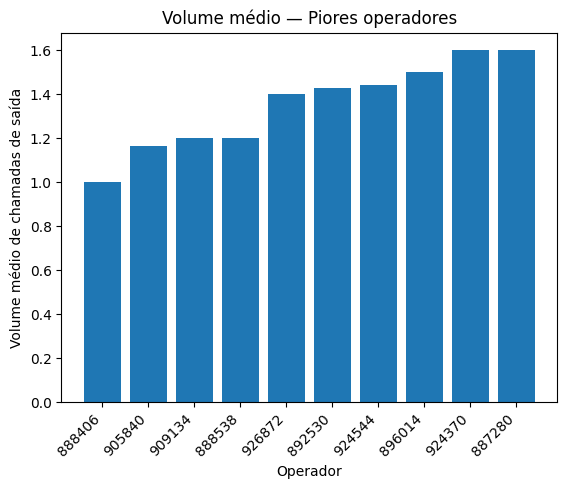

In [43]:
plt.figure()

plt.bar(
    top_10['operator_id'].astype(str),
    top_10['calls_count']
)

plt.ylabel('Volume médio de chamadas de saída')
plt.xlabel('Operador')
plt.title('Volume médio — Piores operadores')
plt.xticks(rotation=45, ha='right')

plt.show()

Mesmo após a filtragem por atividade mínima, foi identificado um grupo de operadores com volume médio diário de chamadas outbound persistentemente baixo, variando entre aproximadamente 1 e 1,6 chamadas por dia, ao longo de múltiplos dias ativos.

Esse padrão indica baixa produtividade outbound consistente, e não um efeito causado por baixa disponibilidade ou poucos dias de operação. Esses operadores representam candidatos prioritários para revisão de alocação, treinamento ou redistribuição de tarefas.

5. Teste de hipóteses estatísticas

<div class="alert alert-block alert-danger">
<b> Comentário Geral do revisor: </b> <a class="tocSkip"></a>

Não faz sentido testar um operador vs os demais. Precisamos pensar em duas amostras. Por exemplo, será que você consegue a taxa média de chamadas perdidas para duas categorias de operadores?
</div>


<div class="alert alert-block alert-danger">
<b> Comentário Geral do revisor v2: </b> <a class="tocSkip"></a>

Você está usando a mesma variável taxa_abandono para recortar as amostras e para testar a hipótese. Exemplo, a média do peso entre do grupo acima de 50kg é diferente da média do peso do grupo abaixo de 50kg. Isso não faz sentido. Faria sentido se o teste usasse oura variável para fazer o recorte: a média do peso entre do grupo acima de 50 anos é diferente da média do peso do grupo abaixo de 50 anos. Percebe a didferença? 
</div>


<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> 
    Entendi, obrigada pela explicação. Conforme orientação anterior optei por excluir o teste de hipótese sobre taxa de abandono, tendo em vista que os outros testes estão corretos. <a class="tocSkip"></a>
</div>

*Teste 1*

H₀ (nula): O tempo médio de espera é igual entre operadores críticos e regulares.

H₁ (alternativa): Operadores críticos apresentam tempo médio de espera maior que operadores regulares.


In [44]:
abandono_op = abandono_op.dropna(subset=['taxa_abandono_operador'])

Q1 = abandono_op['taxa_abandono_operador'].quantile(0.25)
Q3 = abandono_op['taxa_abandono_operador'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR

abandono_op['grupo'] = np.where(
    abandono_op['taxa_abandono_operador'] > limite_superior,
    'Crítico',
    'Regular'
)

abandono_op['grupo'].value_counts()

Regular    627
Crítico    127
Name: grupo, dtype: int64

In [45]:
df_analise = operadores_final.merge(
    abandono_op[['operator_id', 'grupo']],
    on='operator_id',
    how='inner'
)

amostra_criticos = df_analise[
    df_analise['grupo'] == 'Crítico'
]['tempo_espera_medio'].dropna()

amostra_regulares = df_analise[
    df_analise['grupo'] == 'Regular'
]['tempo_espera_medio'].dropna()

print('Críticos:', amostra_criticos.shape[0])
print('Regulares:', amostra_regulares.shape[0])

print('Média críticos:', amostra_criticos.mean())
print('Média regulares:', amostra_regulares.mean())

Críticos: 127
Regulares: 627
Média críticos: 54.878826227031894
Média regulares: 57.93751118994644


In [46]:
stat, p_value = mannwhitneyu(
    amostra_criticos,
    amostra_regulares,
    alternative='greater'
)

alpha = 0.05

print('p-value:', p_value)

if p_value < alpha:
    print(
        'Existe evidência estatística de que operadores críticos '
        'apresentam tempo médio de espera maior que operadores regulares (p < 0,05).'
    )
else:
    print(
        'Não foi encontrada evidência estatística suficiente para afirmar '
        'diferença no tempo médio de espera entre os grupos.'
    )

p-value: 0.00843920437728688
Existe evidência estatística de que operadores críticos apresentam tempo médio de espera maior que operadores regulares (p < 0,05).


<div class="alert alert-block alert-danger">
<b> Comentário Geral do revisor: </b> <a class="tocSkip"></a>

Este teste não faz sentido pois você recortou as amostras usando a variável do teste, ou seja, você já definiu duas amostras difentes. Podemos definir duas amoastras em função de outro parâmetro que não tempo_espera_medio 

</div>


<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> 
    Eu criei as duas amostras e também alterei as hipóteses para ficar mais clara. Acredito que o resultado faça sentido agora, tendo em vista o gráfico anterior sobre tempo de espera médio e que obrigatoriamente os piores tem que ter tempos maiores que e os regulares. <a class="tocSkip"></a>
</div>

<div class="alert alert-block alert-success">
<b> Comentário do revisor V2: </b> <a class="tocSkip"></a>

Correto
</div>


*Teste 2*

H₀: A média de chamadas realizadas pelos operadores experientes é igual à média dos operadores novos.

H₁: A média de chamadas realizadas pelos operadores experientes é maior que a dos operadores novos.

In [47]:
df_test2 = out_produtividade[
    out_produtividade['dias_ativos_outbound'] >= 5
].copy()

grupo_experientes = df_test2[
    df_test2['dias_ativos_outbound'] >= 30
]['calls_count']

grupo_novos = df_test2[
    df_test2['dias_ativos_outbound'] < 30
]['calls_count']

grupo_experientes = grupo_experientes.dropna()
grupo_novos = grupo_novos.dropna()

t_stat, p_value = ttest_ind(
    grupo_experientes,
    grupo_novos,
    equal_var=False,
    alternative='greater'
)

t_stat, p_value

(-0.2834005860011213, 0.6114437875676373)

In [48]:
alpha = 0.05

if p_value < alpha:
    print(
        "O teste t indicou que operadores com maior tempo de atuação "
        "realizam significativamente mais chamadas do que operadores novos "
        "(p < 0,05)."
    )
else:
    print(
        "Não foi encontrada evidência estatística suficiente para afirmar que "
        "operadores experientes realizam mais chamadas do que operadores novos."
    )

Não foi encontrada evidência estatística suficiente para afirmar que operadores experientes realizam mais chamadas do que operadores novos.


In [49]:
grupo_experientes.mean(), grupo_novos.mean(), len(grupo_experientes), len(grupo_novos)

(40.24331979645742, 42.72356859515459, 168, 448)

<div class="alert alert-block alert-danger">
<b> Comentário Geral do revisor: </b> <a class="tocSkip"></a>

Este teste não faz sentido pois você recortou as amostras usando a variável do teste, ou seja, você já definiu duas amostras difentes. Podemos definir duas amoastras em função de outro parâmetro que não tempo_espera_medio 

</div>


<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> 
    Eu criei as duas amostras e também alterei as hipóteses para ficar mais clara.<a class="tocSkip"></a>
</div>

<div class="alert alert-block alert-success">
<b> Comentário do revisor V2: </b> <a class="tocSkip"></a>

Correto
</div>


Para a comparação estatística entre grupos de operadores, foram utilizados testes paramétricos e não-paramétricos conforme as características dos dados. O teste t de Welch foi aplicado quando o objetivo foi comparar médias entre grupos independentes, aproveitando sua robustez a variâncias desiguais. Já o teste de Mann-Whitney foi empregado em cenários com distribuições assimétricas e presença de outliers, permitindo a comparação das distribuições sem assumir normalidade. Essa abordagem garante que os resultados não dependam de premissas estatísticas frágeis e sejam interpretáveis no contexto do negócio.

## Agrupamento de operadores (KMeans)

In [50]:
features = operadores_final[
    ['taxa_abandono_operador', 'tempo_espera_medio', 'chamadas', 'dias_ativos']
].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

features['cluster'] = clusters

features.groupby('cluster').mean()

,taxa_abandono_operador,tempo_espera_medio,chamadas,dias_ativos
cluster,,,,
0,0.019318,34.259307,141.387681,10.849638
1,0.020321,111.140777,66032.500000,88.500000
2,0.011208,120.815056,1366.565000,47.340000


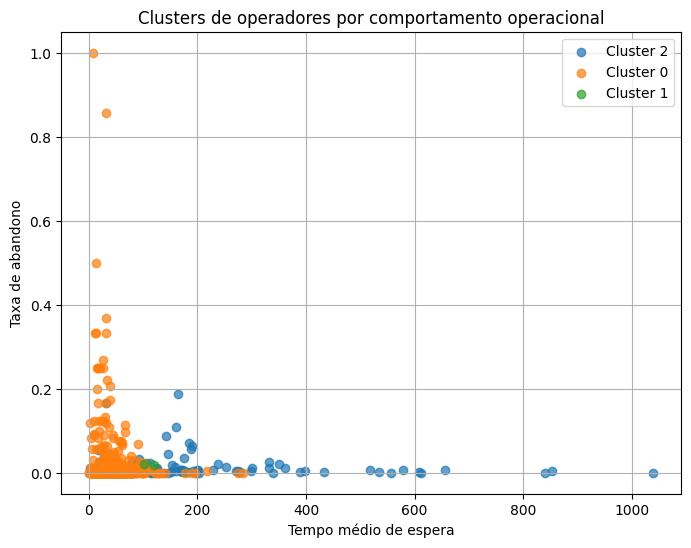

In [51]:
plt.figure(figsize=(8,6))

for c in features['cluster'].unique():
    subset = features[features['cluster'] == c]
    plt.scatter(
        subset['tempo_espera_medio'],
        subset['taxa_abandono_operador'],
        label=f'Cluster {c}',
        alpha=0.7
    )

plt.xlabel('Tempo médio de espera')
plt.ylabel('Taxa de abandono')
plt.title('Clusters de operadores por comportamento operacional')
plt.legend()
plt.grid(True)

plt.show()

O gráfico de clusters evidencia a existência de grupos distintos de operadores quando analisados simultaneamente pelo tempo médio de espera e pela taxa de abandono. Observa-se uma grande concentração de operadores com baixo tempo de espera e baixa taxa de abandono, caracterizando o grupo operacionalmente mais eficiente. Em contrapartida, surgem clusters menores e isolados que indicam comportamentos atípicos, como operadores com baixa espera e alta taxa de abandono, sugerindo possíveis problemas de roteamento, falhas de fila ou abandono precoce do cliente, e operadores com tempos de espera elevados, mas taxas de abandono relativamente baixas, indicando retenção apesar da lentidão. Esses agrupamentos mostram que a ineficiência não é homogênea e que diferentes perfis exigem estratégias de intervenção específicas, reforçando a utilidade de técnicas de clusterização para segmentação operacional.

## Análise de correlação

In [52]:
corr = operadores_final[
    ['taxa_abandono_operador', 'tempo_espera_medio', 'chamadas']
].corr()

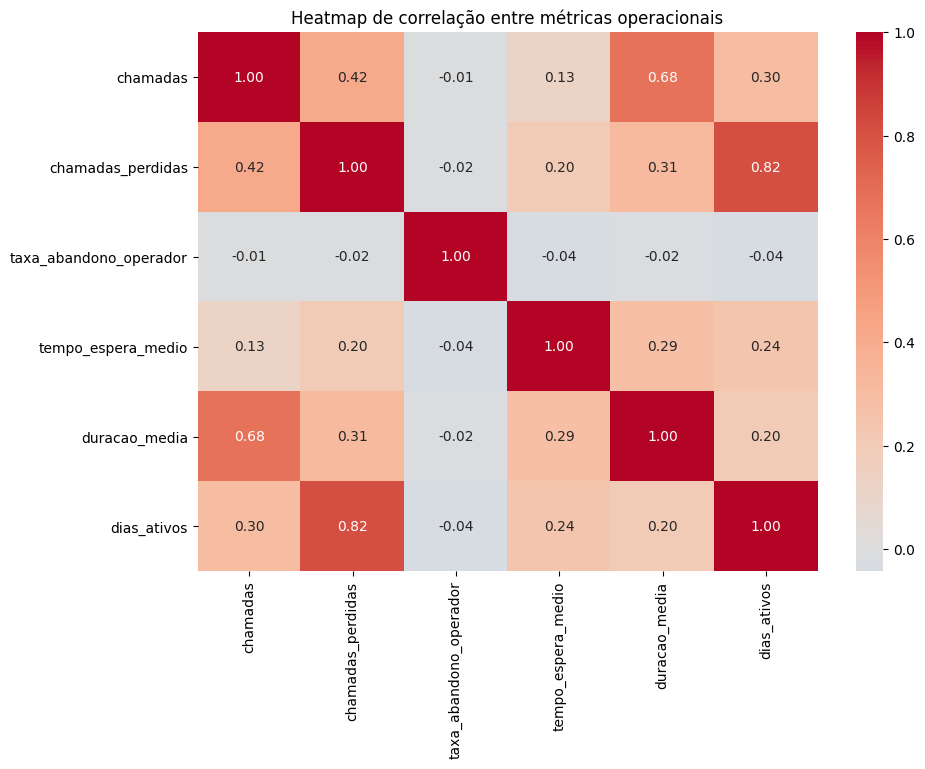

In [53]:
cols = [
    'chamadas',
    'chamadas_perdidas',
    'taxa_abandono_operador',
    'tempo_espera_medio',
    'duracao_media',
    'dias_ativos'
]

corr = operadores_final[cols].corr()

plt.figure(figsize=(10,7))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0
)

plt.title('Heatmap de correlação entre métricas operacionais')
plt.show()

O heatmap de correlação mostra que variáveis relacionadas a volume e carga de trabalho apresentam relações moderadas, como a correlação positiva entre número de chamadas e duração média, e entre chamadas perdidas e dias ativos, indicando maior exposição operacional ao longo do tempo. No entanto, a taxa de abandono do operador apresenta correlação próxima de zero com todas as demais métricas analisadas, incluindo tempo médio de espera e volume de chamadas. Esse resultado sugere que o abandono não é explicado de forma linear pelo desempenho individual do operador, mas possivelmente por fatores sistêmicos, como estrutura de filas, horários de pico ou características das chamadas. Assim, a análise reforça que métricas isoladas não são suficientes para explicar ineficiência, sendo necessária uma abordagem multivariada para interpretação adequada do desempenho operacional.

## Análises de coort

In [54]:
df_merged = df_.merge(
    df2[['user_id', 'mes']],
    on='user_id',
    how='inner',
    suffixes=('_atividade', '_cohort')
)

df_merged['period'] = df_merged['mes_atividade'] - df_merged['mes_cohort']
df_merged = df_merged[df_merged['period'] >= 0]

In [55]:
cohort_activity = (
    df_merged
    .groupby(['mes_cohort', 'period'])['user_id']
    .nunique()
    .reset_index(name='clientes_ativos')
)

In [56]:
cohort_sizes = (
    df2
    .groupby('mes')['user_id']
    .nunique()
)

In [57]:
cohort_activity['retencao'] = (
    cohort_activity['clientes_ativos']
    / cohort_activity['mes_cohort'].map(cohort_sizes)
)

cohort_activity[cohort_activity['period'] == 0]['retencao'].unique()

array([0.26356589, 0.2987013 , 0.31687243])

In [58]:
cohort_pivot = cohort_activity.pivot(
    index='mes_cohort',
    columns='period',
    values='retencao'
)

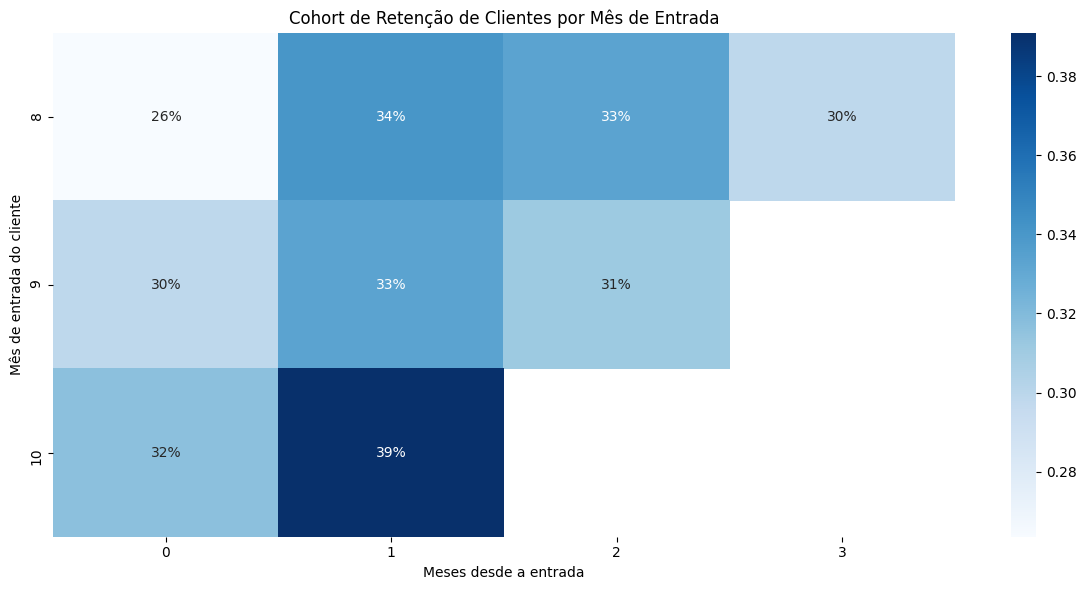

In [59]:
plt.figure(figsize=(12, 6))

sns.heatmap(
    cohort_pivot,
    annot=True,
    fmt=".0%",
    cmap="Blues"
)

plt.title("Cohort de Retenção de Clientes por Mês de Entrada")
plt.xlabel("Meses desde a entrada")
plt.ylabel("Mês de entrada do cliente")
plt.tight_layout()
plt.show()

A principal dor está na ativação inicial dos clientes, com retenção abaixo de 35% já no primeiro mês, seguida de uma queda gradual, indicando dificuldade em transformar uso pontual em recorrente.

In [60]:

df2['date_start'] = pd.to_datetime(df2['date_start'])
df_['date'] = pd.to_datetime(df_['date'])


df2['cohort_mes'] = df2['date_start'].dt.to_period('M')
df_['mes_atividade'] = df_['date'].dt.to_period('M')

In [61]:

df_cohort = df_.merge(
    df2[['user_id', 'tariff_plan', 'cohort_mes']],
    on='user_id',
    how='inner'
)

In [62]:
df_cohort['meses_desde_entrada'] = (
    df_cohort['mes_atividade'] - df_cohort['cohort_mes']
).apply(lambda x: x.n)

In [63]:
df_cohort = df_cohort[df_cohort['meses_desde_entrada'] >= 0]

In [64]:
cohort_base = (
    df2
    .groupby(['tariff_plan', 'cohort_mes'])['user_id']
    .nunique()
)

In [65]:
cohort_activity = (
    df_cohort
    .groupby(['tariff_plan', 'cohort_mes', 'meses_desde_entrada'])['user_id']
    .nunique()
    .reset_index()
)

cohort_pivot = cohort_activity.pivot_table(
    index=['tariff_plan', 'cohort_mes'],
    columns='meses_desde_entrada',
    values='user_id'
)

cohort_retention = cohort_pivot.div(cohort_base, axis=0)

In [66]:
(cohort_retention > 1).any().any()

False

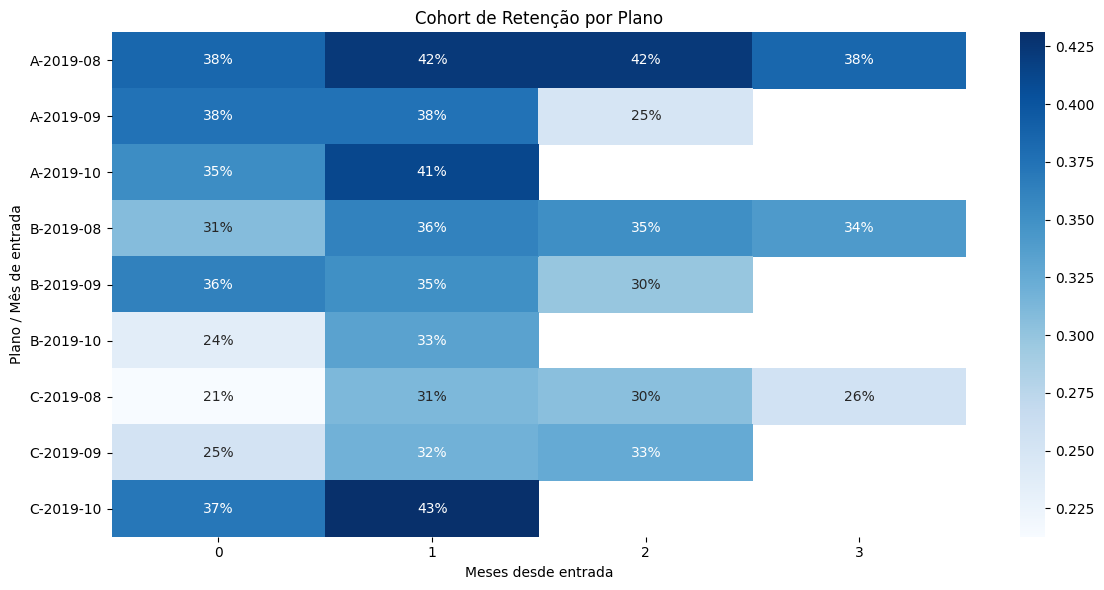

In [67]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    cohort_retention,
    annot=True,
    fmt='.0%',
    cmap='Blues'
)
plt.title('Cohort de Retenção por Plano')
plt.xlabel('Meses desde entrada')
plt.ylabel('Plano / Mês de entrada')
plt.tight_layout()
plt.show()

A análise de cohort de retenção por plano evidencia que o principal desafio do negócio está concentrado nos primeiros meses após a entrada dos clientes, indicando um padrão de churn precoce consistente entre todos os planos. O plano A apresenta maior retenção inicial, sugerindo facilidade de adesão, porém sofre quedas relevantes nos meses seguintes, o que pode indicar que o valor percebido não se sustenta ao longo do tempo. O plano B, apesar de atrair um volume inicial menor de clientes, demonstra maior estabilidade de retenção, sugerindo um público mais qualificado ou melhor alinhado ao produto. Já o plano C apresenta menor retenção no mês de entrada, mas uma melhora significativa no mês seguinte, indicando uma curva de aprendizado mais longa, porém maior fidelização entre os clientes que superam a fase inicial. Esses resultados sugerem que estratégias de ativação e onboarding nos primeiros meses são críticas para reduzir churn, especialmente para os planos A e C, e que o perfil de clientes do plano B pode servir como referência para aprimorar a segmentação e o posicionamento dos demais planos.

## Obtenção do arquivo para o Tableau

In [68]:
operadores_final.to_csv('operadores_final_dashboard.csv', index=False)
df_.to_csv('calls.csv',index=False)
df2.to_csv('clients.csv',index=False)

## Link Dashboard

https://public.tableau.com/views/ProjetoFinal_17683356818040/Painel1?:language=pt-BR&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

## Link Relatório

https://drive.google.com/file/d/1YiWCJbJzkkmWbPukoHUDy3Ya6iDdTDB7/view?usp=sharing